In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import Data

In [3]:
df = pd.read_csv('transactions_n100000.csv')

In [4]:
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x7901ee,2019-01-16 18:33:00,7,shake,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,burger,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,fries,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salad,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,fries,1,41.884490,-87.627059


In [5]:
df.shape

(260645, 7)

In [6]:
grouped_df = df.groupby(by='ticket_id').first().drop(['item_name','item_count'],axis=1)

In [8]:
grouped_df

,order_timestamp,location,lat,long
ticket_id,,,,
0x10000a,2019-01-29 00:48:00,9,41.524598,-87.849468
0x100058,2019-05-05 00:08:00,6,41.784576,-87.607565
0x1000c8,2019-01-28 19:24:00,9,41.524598,-87.849468
0x10014c,2019-02-23 00:15:00,6,41.784576,-87.607565
0x1001d8,2019-06-30 17:50:00,2,42.049306,-87.677606
...,...,...,...,...
0xffe96,2019-01-05 19:28:00,4,41.889047,-87.803605
0xffeed,2019-08-08 00:42:00,2,42.049306,-87.677606
0xfff07,2019-05-04 00:48:00,2,42.049306,-87.677606


In [9]:
item_types = pd.pivot_table(df,index='ticket_id',columns='item_name',values='item_count').fillna(0)

In [140]:
new_df = grouped_df.merge(item_types,left_on='ticket_id',right_on='ticket_id')

In [141]:
new_df.head()

,order_timestamp,location,lat,long,burger,fries,salad,shake
ticket_id,,,,,,,,
0x10000a,2019-01-29 00:48:00,9,41.524598,-87.849468,1.0,1.0,0.0,0.0
0x100058,2019-05-05 00:08:00,6,41.784576,-87.607565,2.0,2.0,0.0,0.0
0x1000c8,2019-01-28 19:24:00,9,41.524598,-87.849468,4.0,5.0,1.0,4.0
0x10014c,2019-02-23 00:15:00,6,41.784576,-87.607565,1.0,1.0,0.0,0.0
0x1001d8,2019-06-30 17:50:00,2,42.049306,-87.677606,3.0,3.0,0.0,3.0


In [142]:
new_df.shape

(100000, 8)

## Feature Engineering

In [143]:
new_df['order_timestamp'] = pd.to_datetime(new_df['order_timestamp'])
new_df['hour'] = new_df['order_timestamp'].dt.hour
new_df['day_of_week'] = new_df['order_timestamp'].dt.dayofweek

In [144]:
new_df = new_df.drop(['lat','long','order_timestamp'],axis=1)

In [145]:
#Based on Tableau Analytics:

def classify_location(loc):
    if loc in [1,3,5,8]:
        label = 'Chicago_City'
        #loc 8 is in Chicago prime location - Magnificent Mile
        #loc 5 is close to the central train station
    elif loc in [2,6]:
        label = 'University'
        #specifically, location 2 is near Northwestern, 6 is near UChic
    else:
        label = 'Suburban'
    return label

def classify_day_of_week(day):
    if day <= 4:
        label = 'weekday'
    else:
        label = 'weekend'
    return label

def classify_time_of_day(time):
    if (time >= 6) and (time <= 10):
        #6am-10am
        label = 'morning'
    elif (time >= 10) and (time <= 16):
        #10am- 4pm
        label = 'afternoon'
    elif (time >= 16) and (time <= 21):
        #4pm-9pm
        label = 'evening'
    else:
        #9pm-4am
        label = 'late_night'
    return label

In [146]:
#new_df['location_type'] = new_df.location.apply(classify_location)
new_df['week_day'] = new_df.day_of_week.apply(classify_day_of_week)
new_df['time_of_day'] = new_df.hour.apply(classify_time_of_day)

new_df = new_df.drop(['day_of_week','hour'],axis=1)

In [147]:
new_df.head()

,location,burger,fries,salad,shake,week_day,time_of_day
ticket_id,,,,,,,
0x10000a,9,1.0,1.0,0.0,0.0,weekday,late_night
0x100058,6,2.0,2.0,0.0,0.0,weekend,late_night
0x1000c8,9,4.0,5.0,1.0,4.0,weekday,evening
0x10014c,6,1.0,1.0,0.0,0.0,weekend,late_night
0x1001d8,2,3.0,3.0,0.0,3.0,weekend,evening


In [148]:
#Basically do One Hot Encoding

list_of_cols = ['location','week_day','time_of_day']

for var in list_of_cols:
    cat_list = pd.get_dummies(new_df[var])
    new_df = new_df.join(cat_list)

new_df = new_df.drop(list_of_cols,axis=1)

In [149]:
new_df.head()

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,weekday,weekend,afternoon,evening,late_night
ticket_id,,,,,,,,,,,,,,,,,,
0x10000a,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
0x100058,2.0,2.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
0x1000c8,4.0,5.0,1.0,4.0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
0x10014c,1.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
0x1001d8,3.0,3.0,0.0,3.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0


In [150]:
new_df.describe()

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,weekday,weekend,afternoon,evening,late_night
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000
mean,1.857840,2.569210,0.711370,1.239590,0.085650,0.157110,0.08718,0.112820,0.084040,0.156800,0.113510,0.089570,0.113320,0.71413,0.28587,0.342460,0.318850,0.338690
std,1.588589,1.332084,1.086524,1.627886,0.279848,0.363906,0.28210,0.316374,0.277449,0.363614,0.317217,0.285566,0.316985,0.45183,0.45183,0.474535,0.466033,0.473267
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.00000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,1.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.00000,1.000000,1.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000


In [151]:
#Ran the first time, found that weekday/weekend split not impt, so im removing it

new_df.drop(['weekday','weekend'],axis=1,inplace=True)

## Train-Test Split and Standardization

In [152]:
from sklearn import model_selection

train,test = model_selection.train_test_split(new_df, test_size=0.3, random_state = 0)

In [153]:
from sklearn import preprocessing

In [154]:
Scaler = preprocessing.MinMaxScaler()
train_scaled = Scaler.fit_transform(train)
test_scaled = Scaler.transform(test)

In [155]:
train_scaled = pd.DataFrame(train_scaled, columns = train.columns,index= train.index)
test_scaled = pd.DataFrame(test_scaled,columns = test.columns,index= test.index)

In [156]:
train_scaled

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night
ticket_id,,,,,,,,,,,,,,,,
0x4a72e9,0.4,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
0x8d79fc,0.2,0.25,0.2,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0x6ab655,0.4,0.25,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
0x7c6441,0.0,0.00,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0x22521b,0.4,0.75,0.4,0.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x2cfec2,0.0,1.00,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0x4ea503,0.2,0.25,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0x4a1790,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [180]:
# Try with the standard scaler?

Std_Scale = preprocessing.StandardScaler()
train_std_scaled = Std_Scale.fit_transform(train)

train_std_scaled = pd.DataFrame(train_std_scaled, columns = train.columns,index= train.index)

train_std_scaled

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night
ticket_id,,,,,,,,,,,,,,,,
0x4a72e9,0.087918,-0.428216,-0.655473,-0.763719,-0.306382,-0.430833,-0.307385,-0.357459,-0.301868,2.314704,-0.359743,-0.312424,-0.358145,-0.719363,-0.687729,1.399850
0x8d79fc,-0.541226,-0.428216,0.267209,-0.149882,3.263904,-0.430833,-0.307385,-0.357459,-0.301868,-0.432021,-0.359743,-0.312424,-0.358145,1.390118,-0.687729,-0.714362
0x6ab655,0.087918,-0.428216,-0.655473,0.463956,-0.306382,-0.430833,-0.307385,-0.357459,-0.301868,-0.432021,2.779765,-0.312424,-0.358145,-0.719363,1.454061,-0.714362
0x7c6441,-1.170370,-1.178608,0.267209,-0.763719,-0.306382,-0.430833,3.253252,-0.357459,-0.301868,-0.432021,-0.359743,-0.312424,-0.358145,1.390118,-0.687729,-0.714362
0x22521b,0.087918,1.072567,1.189890,-0.149882,-0.306382,-0.430833,-0.307385,-0.357459,-0.301868,2.314704,-0.359743,-0.312424,-0.358145,1.390118,-0.687729,-0.714362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x2cfec2,-1.170370,1.822959,3.957934,-0.763719,-0.306382,-0.430833,3.253252,-0.357459,-0.301868,-0.432021,-0.359743,-0.312424,-0.358145,1.390118,-0.687729,-0.714362
0x4ea503,-0.541226,-0.428216,0.267209,-0.763719,-0.306382,-0.430833,3.253252,-0.357459,-0.301868,-0.432021,-0.359743,-0.312424,-0.358145,1.390118,-0.687729,-0.714362
0x4a1790,-0.541226,-1.178608,-0.655473,-0.763719,-0.306382,-0.430833,-0.307385,-0.357459,-0.301868,2.314704,-0.359743,-0.312424,-0.358145,-0.719363,-0.687729,1.399850


## Clustering

In [157]:
from sklearn.cluster import KMeans

In [181]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(train_std_scaled)

In [182]:
columns = train_scaled.columns
centers = kmeans.cluster_centers_

pd.DataFrame(data=centers,columns=columns)

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night
0,-0.080660,-0.591120,-0.608548,-0.567109,-0.201387,0.671364,-0.192217,-0.266289,-0.226953,0.666810,-0.269287,-0.205220,-0.267646,-0.715323,-0.675150,1.383384
1,-0.946133,-0.242465,1.089432,-0.680303,0.402746,-0.322946,0.389054,-0.216832,0.414207,-0.321997,-0.224353,0.385216,-0.225378,1.314699,-0.627674,-0.698055
2,1.046110,0.849951,-0.489089,1.271490,-0.204865,-0.355811,-0.200269,0.492506,-0.190462,-0.352132,0.503227,-0.183096,0.502597,-0.609659,1.328079,-0.699953


In [183]:
labels = pd.DataFrame(data= kmeans.labels_)
print(labels[0].value_counts(normalize=True))

0    0.335671
1    0.335243
2    0.329086
Name: 0, dtype: float64


## "Validation"

In [176]:
Sum_of_squared_distances = []
K = range(1,10)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train)
    Sum_of_squared_distances.append(km.inertia_)

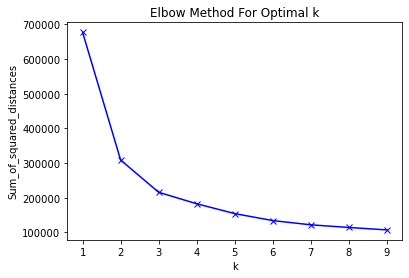

In [177]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [178]:
print(Sum_of_squared_distances)

[677563.2407428571, 308990.3892431887, 215845.2032778915, 182761.28706174073, 154369.74310098367, 134225.18367994673, 121990.31365166426, 114400.01584435378, 107307.10617042042]


In [184]:
labels = pd.DataFrame(data= kmeans.predict(test_scaled))
labels[0].value_counts(normalize=True)

0    0.338367
2    0.335133
1    0.326500
Name: 0, dtype: float64

## Looking at the Mean Characteristics

In [166]:
transformed = Scaler.inverse_transform(train_scaled)

train_scaled_transformed = pd.DataFrame(transformed, columns = train.columns,index= train.index)

In [167]:
#Putting Labels back into DF
train_scaled_transformed['cluster_labels'] = kmeans.labels_

In [168]:
train_scaled_transformed.head()

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night,cluster_labels
ticket_id,,,,,,,,,,,,,,,,,
0x4a72e9,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2
0x8d79fc,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
0x6ab655,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
0x7c6441,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
0x22521b,2.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [169]:
train_scaled_transformed.groupby(by='cluster_labels').mean()

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night
cluster_labels,,,,,,,,,,,,,,,,
0,3.401923,3.623175,0.221252,3.218252,0.034538,0.029553,0.035817,0.260553,0.035640,0.031229,0.266111,0.043668,0.262891,0.008557,0.991443,0.0
1,0.501626,2.320269,1.818643,0.276682,0.189044,0.040757,0.186932,0.055243,0.190100,0.041982,0.053385,0.189002,0.053554,1.000000,0.000000,0.0
2,1.742601,1.812447,0.069846,0.320480,0.031625,0.394216,0.034035,0.030272,0.022704,0.393540,0.030611,0.032133,0.030864,0.000000,0.000000,1.0


In [186]:
transformed = Std_Scale.inverse_transform(train_std_scaled)

train_scaled_transformed = pd.DataFrame(transformed, columns = train.columns,index= train.index)

In [187]:
#Putting Labels back into DF
train_scaled_transformed['cluster_labels'] = kmeans.labels_

In [188]:
train_scaled_transformed.groupby(by='cluster_labels').mean()

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night
cluster_labels,,,,,,,,,,,,,,,,
0,1.732051,1.782908,0.050858,0.320296,0.029408,0.400519,0.032345,0.028897,0.020726,0.400051,0.028812,0.030515,0.028727,0.001915,0.005873,0.992212
1,0.356415,2.247539,1.891124,0.135893,0.198619,0.039204,0.195594,0.044573,0.198108,0.040056,0.043124,0.198577,0.042144,0.964248,0.028039,0.007713
2,3.523007,3.703334,0.180326,3.315550,0.028434,0.027262,0.030083,0.269404,0.030821,0.029085,0.274874,0.036812,0.273225,0.052006,0.941179,0.006815


In [189]:
#Both ways of standardizing yield quite similar results, maybe min-max is better in splitting the times of the day